In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.python.client import device_lib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import Model
%matplotlib inline

In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10947312202800307627
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16266690560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2045309987011960189
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [3]:
(x_train, y_train), (x_test, y_test)  = mnist.load_data()

In [4]:
print(f"Train Data Shape : {x_train.shape}")
print(f"Test Data Shape : {x_test.shape}")
print(f"Train Label Shape : {y_train.shape}")
print(f"Test Label Shape : {y_test.shape}")

Train Data Shape : (60000, 28, 28)
Test Data Shape : (10000, 28, 28)
Train Label Shape : (60000,)
Test Label Shape : (10000,)


In [5]:
print ("Dimensions of x_train:" + str(x_train[0].shape))
print ("Labels in x_train:" + str(y_train.shape))
print("\n")
print ("Dimensions of x_test:" + str(x_test[0].shape))
print ("Labels in y_test:" + str(y_test.shape))

Dimensions of x_train:(28, 28)
Labels in x_train:(60000,)


Dimensions of x_test:(28, 28)
Labels in y_test:(10000,)


# plot some images from train data

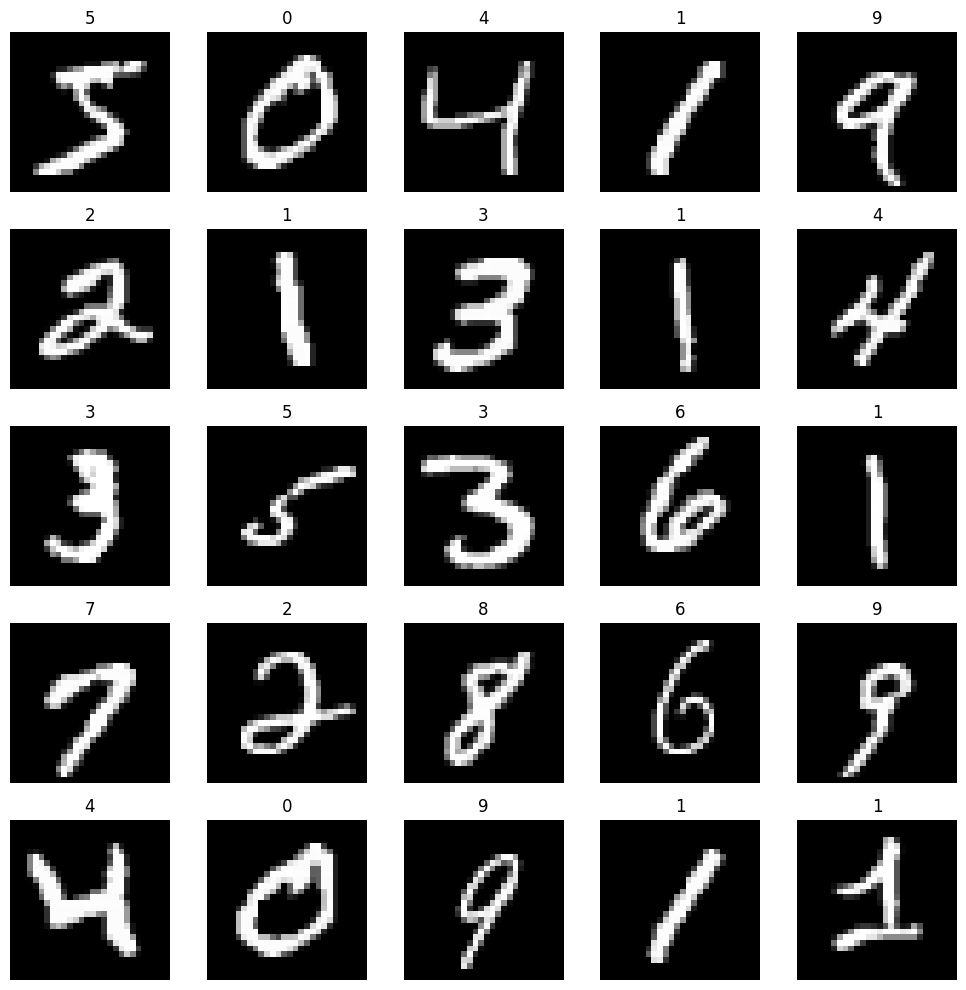

In [6]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Plot the images in a 5x5 grid
for i in range(5):
    for j in range(5):
        # Select the image and label
        index = i * 5 + j
        axes[i, j].imshow(x_train[index], cmap='gray')
        axes[i, j].set_title(str(y_train[index]))
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

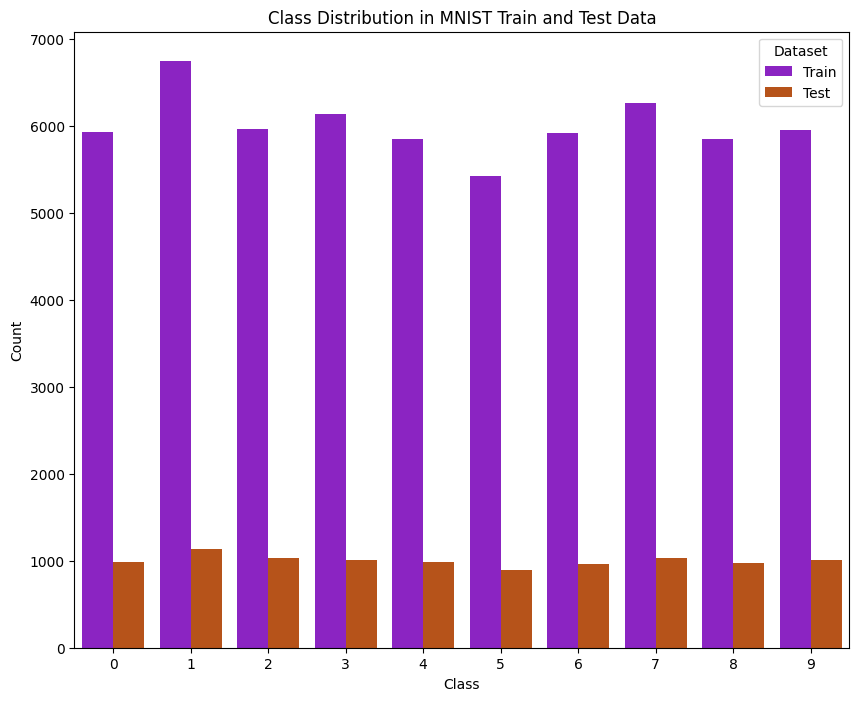

In [7]:
train_class_counts = pd.Series(y_train).value_counts()
test_class_counts = pd.Series(y_test).value_counts()

class_counts = pd.DataFrame({
    'Train': train_class_counts,
    'Test': test_class_counts
}).fillna(0)

class_counts = class_counts.astype(int)

# Reset index to make 'Class' a column for Seaborn
class_counts = class_counts.reset_index()
class_counts = class_counts.rename(columns={'index': 'Class'})

# Melt the dataframe to long format for Seaborn
class_counts_melted = class_counts.melt(id_vars=['Class'], 
                                      var_name='Dataset', 
                                      value_name='Count')

# Create Seaborn barplot
plt.figure(figsize=(10, 8))
sns.barplot(data=class_counts_melted, 
            x='Class', 
            y='Count', 
            hue='Dataset',palette="gnuplot")

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in MNIST Train and Test Data')
plt.show()

# preprocess Data

In [8]:
# Lets store the number of rows and columns
img_rows = x_train[0].shape[0]
img_cols = x_train[0].shape[1]

# Getting our data in the right 'shape' needed for Keras
# We need to add a 4th dimenion to our data thereby changing our
# Our original image shape of (60000,28,28) to (60000,28,28,1)
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

# store the shape of a single image 
input_shape = (img_rows, img_cols, 1)

# change our image type to float32 data type
x_train = x_train.astype('float32') #uint8 originally
x_test = x_test.astype('float32')

# Normalize our data by changing the range from (0 to 255) to (0 to 1)
x_train /= 255.0
x_test /= 255.0


from tensorflow.keras.utils import to_categorical

# Now we one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Let's count the number columns in our hot encoded matrix 
print ("Number of Classes: " + str(y_test.shape[1]))

num_classes = y_test.shape[1]


Number of Classes: 10


# Create Model

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer=AdamW(learning_rate=0.001),  
              metrics=['accuracy'])

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
history = model.fit(x_train,
                    y_train,
                    batch_size = 32,
                    epochs = 10,
                    verbose = 1,
                    validation_data = (x_test, y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9222 - loss: 0.2443 - val_accuracy: 0.9872 - val_loss: 0.0388
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9878 - loss: 0.0371 - val_accuracy: 0.9866 - val_loss: 0.0384
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9932 - loss: 0.0223 - val_accuracy: 0.9875 - val_loss: 0.0379
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9949 - loss: 0.0154 - val_accuracy: 0.9884 - val_loss: 0.0403
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9970 - loss: 0.0101 - val_accuracy: 0.9902 - val_loss: 0.0336
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9973 - loss: 0.0089 - val_accuracy: 0.9848 - val_loss: 0.0587
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9978 - loss: 0.0064 - val_accuracy: 0.9917 - val_loss: 0.0350
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9982 - loss: 0.0049 - 

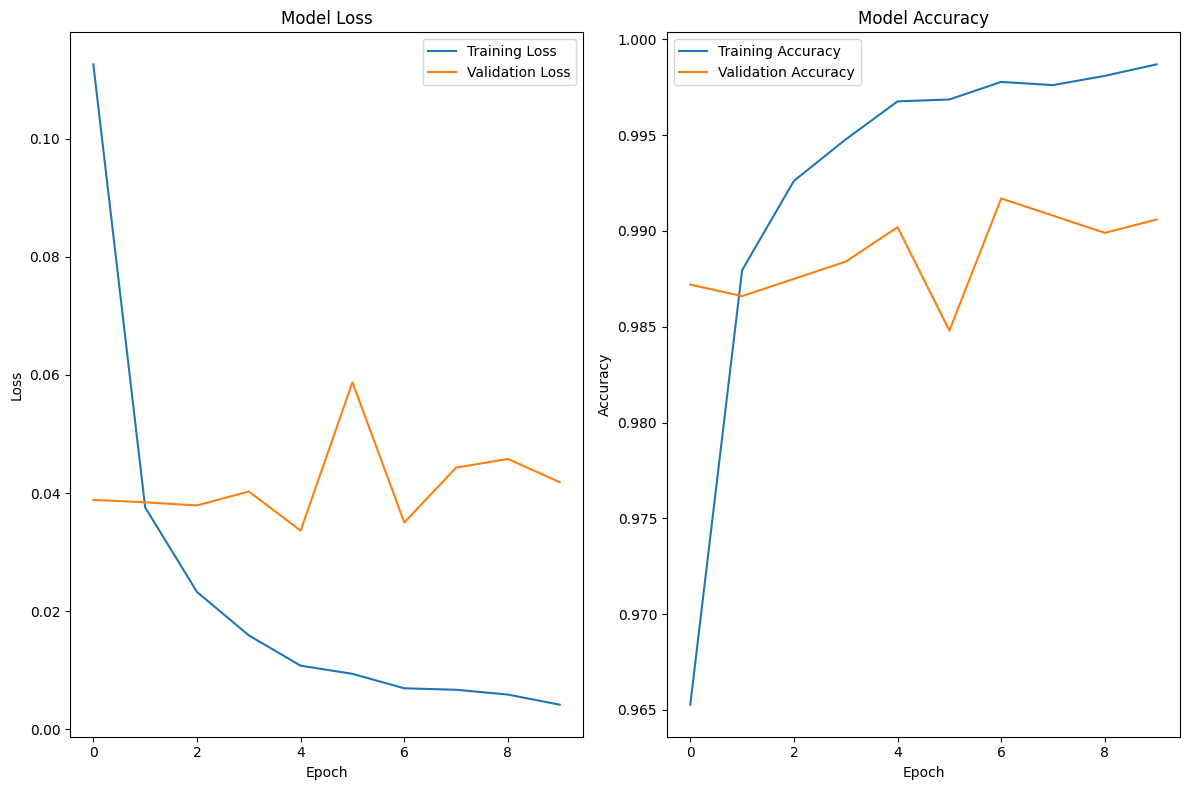

In [11]:
# Plotting Loss and Accuracy
plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0418349988758564
Test accuracy: 0.9905999898910522


# Get the symbolic outputs of each "key" layer (we gave them unique names).

In [13]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict

{'conv2d': <Conv2D name=conv2d, built=True>,
 'conv2d_1': <Conv2D name=conv2d_1, built=True>,
 'max_pooling2d': <MaxPooling2D name=max_pooling2d, built=True>,
 'flatten': <Flatten name=flatten, built=True>,
 'dense': <Dense name=dense, built=True>,
 'dense_1': <Dense name=dense_1, built=True>}

# Get the shapes of only our Conv Filters

In [14]:
# summarize filter shapes
for layer in model.layers:
  # check for convolutional layer
  
  if 'conv' not in layer.name:
    continue

  # get filter weights
  filters, biases = layer.get_weights()
  print(layer.name, filters.shape)

conv2d (3, 3, 1, 32)
conv2d_1 (3, 3, 32, 64)


# Let's take a look at the weights of our first Conv Layer

In [15]:
# retrieve weights from the first Conv (hidden) layer
filters, biases = model.layers[0].get_weights()
print("#"*100)
print(f"Filter Shape : {filters.shape}")
print("#"*100)
print(f"Bias Shape : {biases.shape}")
print("#"*100)

print(f"Filters : {filters}")
print("#"*100)
print("\n")
print(f"Bias : {biases}")
print("#"*100)

####################################################################################################
Filter Shape : (3, 3, 1, 32)
####################################################################################################
Bias Shape : (32,)
####################################################################################################
Filters : [[[[ 0.06177766 -0.18989891 -0.03640886 -0.00797092  0.0192374
    -0.18142277  0.04851072  0.07775474  0.05233598  0.22798628
     0.1374482  -0.21647662 -0.05415233 -0.08685791 -0.2709338
     0.11288398 -0.0322402   0.00976157  0.03777865  0.24095629
    -0.13787748 -0.1911722   0.07215989 -0.17620726  0.05804325
    -0.24009436  0.13549373  0.00090762  0.11583918  0.1477364
     0.03356748 -0.38795426]]

  [[ 0.0611339   0.07007475  0.10713726  0.12880006  0.00800808
    -0.06237649 -0.27027133  0.09154849  0.09816892 -0.05032716
    -0.04070843 -0.17907457  0.07750925  0.11557852 -0.06007468
    -0.08191076  0.20153406  0.2083

# Let's normalize filter values to 0-1 so we can visualize them

In [16]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
print(f'Before Normalisation, Min = {f_min} and Max =  {f_max}')
filters = (filters - f_min) / (f_max - f_min)
print(f'After Normalisation, Min = {filters.min()} and Max =  {filters.max()}')

Before Normalisation, Min = -0.4823276698589325 and Max =  0.3191336691379547
After Normalisation, Min = 0.0 and Max =  1.0


# Visualize our Trained Fillters

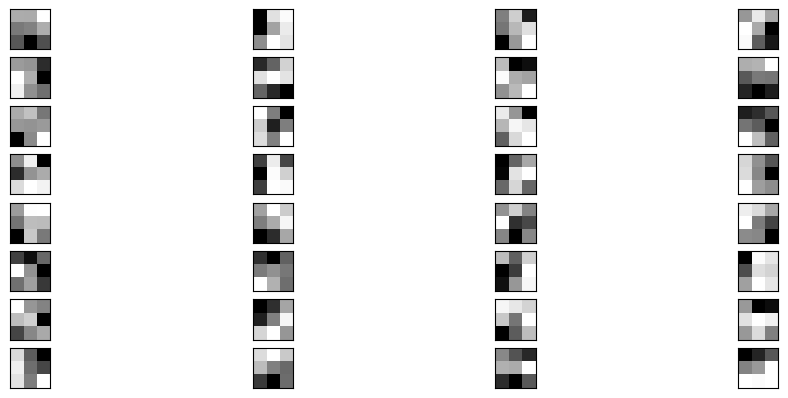

In [17]:
n_filters, ix = 32, 1
plt.figure(figsize=(12,20))

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    #print(f.shape)

    # Arrange in subplot of 4 x 8
    ax = plt.subplot(n_filters, 4, ix)
    ax.set_xticks([])
    ax.set_yticks([])

    # plot filter channel in grayscale
    plt.imshow(np.squeeze(f, axis=2), cmap='gray')
    ix += 1
    
# show the figure
plt.show()

# Filter Activations

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import AdamW

input_shape = (28, 28, 1)
num_classes = 10

inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=AdamW(learning_rate=0.001),
              metrics=['accuracy'])

layer_outputs = [layer.output for layer in model.layers[1:7]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

print("#" * 150)
print(f"Layer Outputs: {layer_outputs}")

######################################################################################################################################################
Layer Outputs: [<KerasTensor shape=(None, 26, 26, 32), dtype=float32, sparse=False, name=keras_tensor_23>, <KerasTensor shape=(None, 24, 24, 64), dtype=float32, sparse=False, name=keras_tensor_24>, <KerasTensor shape=(None, 12, 12, 64), dtype=float32, sparse=False, name=keras_tensor_25>, <KerasTensor shape=(None, 9216), dtype=float32, sparse=False, name=keras_tensor_26>, <KerasTensor shape=(None, 128), dtype=float32, sparse=False, name=keras_tensor_27>, <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_28>]


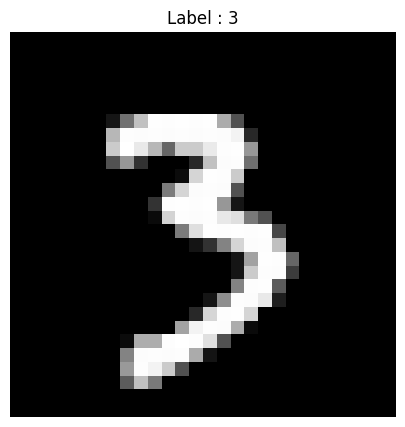

In [19]:
img_tensor = x_test[30].reshape(1,28,28,1)
fig = plt.figure(figsize=(10,5))
plt.imshow(img_tensor[0,:,:,0],cmap="gray")
label=np.argmax(y_test[30] if len(y_test.shape)> 1 else y_test[30])
plt.title(f"Label : {label}")
plt.axis('off')
plt.show()

# Get the output after the 2nd Conv Filter (after ReLU)

In [20]:
activations = activation_model.predict(img_tensor)

print("Number of layer activations: " + str(len(activations)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
Number of layer activations: 6


# The activation of the first convolution layer for the image input

In [21]:
print("#"*150)
first_layer_activation = activations[0]
print(f"First Layer Activation : {first_layer_activation.shape}")
print("#"*150)
second_layer_activation = activations[1]
print(f"Second Layer Activation : {second_layer_activation.shape}")

######################################################################################################################################################
First Layer Activation : (1, 26, 26, 32)
######################################################################################################################################################
Second Layer Activation : (1, 24, 24, 64)


In [22]:
print(model.summary())

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

None


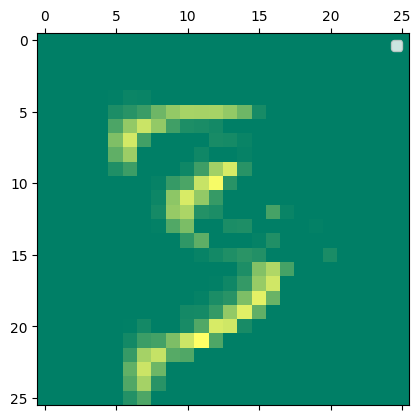

In [23]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap='summer')
plt.legend()

# Create a function that displys the activations of specific layers

In [24]:
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='viridis')
            activation_index += 1

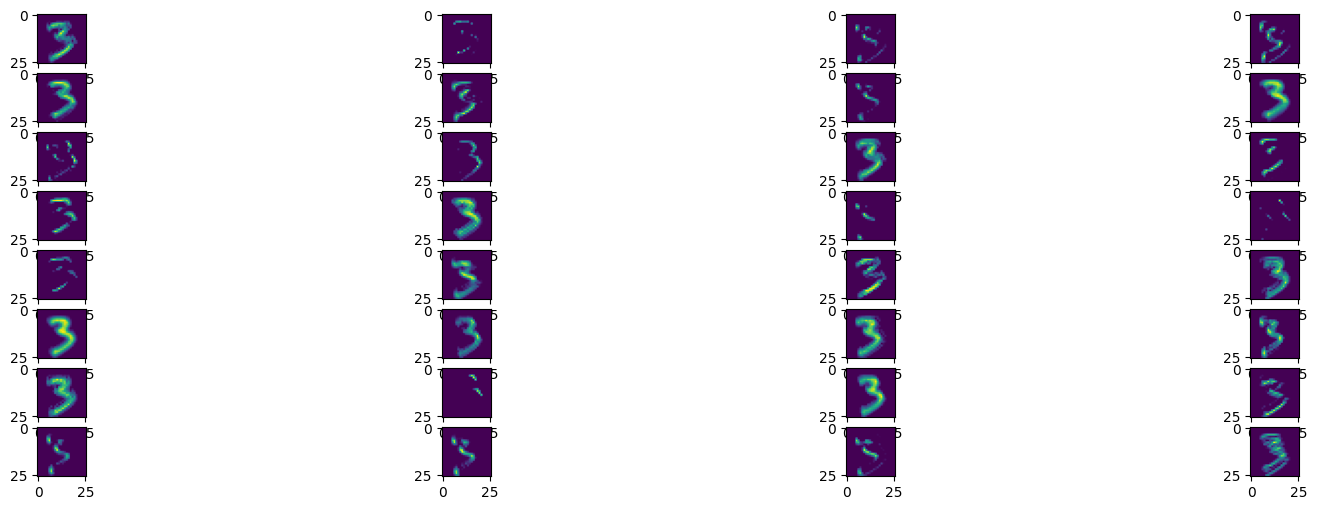

In [25]:
display_activation(activations, 4, 8, 0)